In [1]:
import os
import cv2
import shutil
import PIL
import random
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DRIVE_BASE_DIR = '/content/drive/MyDrive/visione-percezione/progetto/'
#BASE_DIR = '/content/dataset/'
BASE_DIR = '../../dataset/'
DATASET_DIR = BASE_DIR + 'final_dataset/'
DATA_DIR = Path(DATASET_DIR)
SAVED_MODEL_DIR = DRIVE_BASE_DIR + 'model'
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [6]:
EPOCHS = 10
BATCH_SIZE = 32

In [7]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    seed = 123,
    subset = 'training')

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = (IMG_HEIGHT, IMG_WIDTH),
    validation_split = 0.2,
    subset = "validation"
)
class_names = train_ds.class_names
print(class_names)

Found 17066 files belonging to 3 classes.
Using 13653 files for training.
Found 17066 files belonging to 3 classes.
Using 3413 files for validation.
['correctly-masked', 'not-masked', 'uncorrectly-masked']


In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(random.randint(1, 100)):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(), 
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

#hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
#model.compile(loss = 'categorical_crossentropy',
#                optimizer = tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
#                metrics = ['accuracy'])

model.summary()

In [ ]:
start_time = time.time()
epochs = EPOCHS
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
model.save(BASE_DIR+'../model')
print("--- %s seconds ---" % (time.time() - start_time))

In [3]:
model = keras.models.load_model(BASE_DIR+'../model')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
rescaling (Rescaling)        (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)       

In [4]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

32768/26947 [====================================] - 0s 0us/step
This image most likely belongs to not-masked with a 100.00 percent confidence.


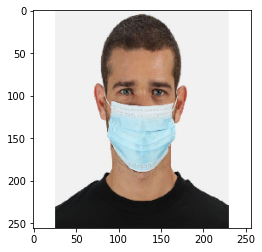

In [9]:
#img_path = "/Users/davide/Documents/Università/VisionePercezione/esame/dataset/incorrectly_masked/32000/32991_Mask_Chin.jpg"
#img = Image.open(img_path)
#img = img.convert('RGB')
#newsize = (IMG_WIDTH, IMG_HEIGHT)
#img = img.resize(newsize)

#img_url = "https://cdn.cliqueinc.com/posts/278702/best-face-moisturizers-278702-1553206513142-square.700x0c.jpg"
img_url = "https://media.dare2b.com/catalog/product/cache/c687aa7517cf01e65c009f6943c2b1e9/T/R/TRP118_500_01_bynder_defined_type_model_01_1622610086.jpg"
img_path = tf.keras.utils.get_file(f'{random.randint(0, 100000)}', origin=img_url)

img = keras.preprocessing.image.load_img(
    img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
)
_ = plt.imshow(img)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)